In [1]:
import pandas as pd
from sklearn.model_selection  import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline         import Pipeline
from sklearn.compose          import ColumnTransformer
from sklearn.preprocessing    import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.ensemble         import RandomForestClassifier
from sklearn.metrics          import classification_report, confusion_matrix
from xgboost                  import XGBClassifier

# 1. Wczytanie danych i usunięcie niepotrzebnych kolumn
df = pd.read_csv("dane/global_cancer_patients_2015_2024.csv")
df = df.drop(columns=['Patient_ID','Year','Country_Region','Treatment_Cost_USD','Survival_Years'],
             errors='ignore')

# 2. Przygotowanie zestawu cech X oraz etykiet y
X = df.drop(columns=['Cancer_Type'])
y = df['Cancer_Type']

# 3. Zakodowanie etykiet klas na liczby
label_enc = LabelEncoder()
y_enc = label_enc.fit_transform(y)

# 4. Podział na zbiór treningowy i testowy
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, random_state=42, stratify=y_enc
)

# 5. Definicja preprocessing: skalowanie dla cech numerycznych i one-hot encoding dla kategorycznych
numeric_features  = ['Age','Genetic_Risk','Air_Pollution','Alcohol_Use','Smoking','Obesity_Level','Target_Severity_Score']
categorical_feats = ['Gender','Cancer_Stage']
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numeric_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feats)
])

# --- A. RandomForestClassifier + GridSearchCV dla klasyfikacji ---
rf_pipe = Pipeline([
    ('preproc', preprocessor),                           # preprocessing
    ('clf',     RandomForestClassifier(random_state=42)) # model RF
])
rf_param_grid = {
    'clf__n_estimators':     [100, 200],  # liczba drzew
    'clf__max_depth':        [None, 10, 20],  # maksymalna głębokość
    'clf__min_samples_split':[2, 5]  # minimalne przykłady do rozcięcia
}
rf_search = GridSearchCV(
    rf_pipe,
    rf_param_grid,
    cv=5,
    scoring='f1_weighted',  # miara F1 ważona przez częstość klas
    n_jobs=-1,
    verbose=1
)
rf_search.fit(X_train, y_train)  # trening i strojenie
print("RF best params:", rf_search.best_params_)

# Predykcja i ewaluacja RF
y_pred_rf = rf_search.predict(X_test)
print("\nRF Classification report:\n",
      classification_report(y_test, y_pred_rf, target_names=label_enc.classes_))
print("RF Confusion matrix:\n", confusion_matrix(y_test, y_pred_rf))

# --- B. XGBClassifier + RandomizedSearchCV dla klasyfikacji ---
xgb_pipe = Pipeline([
    ('preproc', preprocessor),                               # ten sam preprocessing
    ('clf',     XGBClassifier(eval_metric='mlogloss',        # model XGBoost
                              random_state=42))
])
xgb_param_dist = {
    'clf__n_estimators':  [50, 100, 200],   # liczba drzew
    'clf__max_depth':     [3, 6, 10],       # głębokość
    'clf__learning_rate': [0.01, 0.1, 0.2], # szybkość uczenia
    'clf__subsample':     [0.6, 0.8, 1.0]   # ułamek próbek dla każdego drzewa
}
xgb_search = RandomizedSearchCV(
    xgb_pipe,
    xgb_param_dist,
    n_iter=10,
    cv=5,
    scoring='f1_weighted',
    n_jobs=-1,
    verbose=1,
    random_state=42
)
xgb_search.fit(X_train, y_train)  # trening i losowe strojenie
print("\nXGB best params:", xgb_search.best_params_)

# Predykcja i ewaluacja XGB
y_pred_xgb = xgb_search.predict(X_test)
print("\nXGB Classification report:\n",
      classification_report(y_test, y_pred_xgb, target_names=label_enc.classes_))
print("XGB Confusion matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Fitting 5 folds for each of 12 candidates, totalling 60 fits
RF best params: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}

RF Classification report:
               precision    recall  f1-score   support

      Breast       0.12      0.12      0.12      1238
    Cervical       0.13      0.14      0.14      1244
       Colon       0.13      0.15      0.14      1275
    Leukemia       0.13      0.13      0.13      1253
       Liver       0.12      0.12      0.12      1250
        Lung       0.12      0.11      0.12      1232
    Prostate       0.13      0.12      0.13      1262
        Skin       0.12      0.10      0.11      1246

    accuracy                           0.13     10000
   macro avg       0.13      0.13      0.13     10000
weighted avg       0.13      0.13      0.13     10000

RF Confusion matrix:
 [[152 175 172 139 158 136 166 140]
 [162 177 182 171 175 128 139 110]
 [164 160 192 161 167 130 147 154]
 [163 180 156 169 140 155 153 137]
 [

In [2]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics   import mean_squared_error, mean_absolute_error, r2_score

# -- Regresja RandomForest na Target_Severity_Score bez leakage --

# 1. Definiujemy zestaw cech (usunęliśmy kolumnę celu)
numeric_features_reg  = ['Age', 'Genetic_Risk', 'Air_Pollution',
                         'Alcohol_Use', 'Smoking', 'Obesity_Level']
categorical_feats_reg = ['Gender', 'Cancer_Stage']
preprocessor_reg = ColumnTransformer([
    ('num', StandardScaler(), numeric_features_reg),      # skalowanie cech numerycznych
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feats_reg)  # one-hot encoding
])

# 2. Przygotowujemy dane: X_reg to wszystkie cechy bez celu, y_reg to nasz cel
y_reg = df['Target_Severity_Score']
X_reg = df.drop(columns=['Target_Severity_Score'])  # usuwamy tę kolumnę z cech

# Dzielimy na zbiór treningowy i testowy
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

# 3. Tworzymy pipeline: preprocessing + regresor
reg_pipe = Pipeline([
    ('preproc', preprocessor_reg),
    ('reg',     RandomForestRegressor(random_state=42))
])

# 4. Definiujemy siatkę hiperparametrów do GridSearchCV
reg_param_grid = {
    'reg__n_estimators':      [100, 200],  # liczba drzew
    'reg__max_depth':         [None, 10, 20],  # maksymalna głębokość
    'reg__min_samples_split': [2, 5]  # minimalna liczba próbek do podziału
}

# Inicjujemy GridSearchCV z metryką negatywnego MSE
reg_search = GridSearchCV(
    reg_pipe,
    reg_param_grid,
    cv=5,
    scoring='neg_mean_squared_error',  # minimalizujemy MSE
    n_jobs=-1,
    verbose=1
)

# 5. Trenujemy model i wypisujemy najlepsze parametry
reg_search.fit(X_train_reg, y_train_reg)
print("Reg best params:", reg_search.best_params_)

# 6. Predykcja na zbiorze testowym i mierzenie jakości
y_pred_reg = reg_search.predict(X_test_reg)

mse = mean_squared_error(y_test_reg,  y_pred_reg)  # średni błąd kwadratowy
mae = mean_absolute_error(y_test_reg, y_pred_reg) # średni błąd bezwzględny
r2  = r2_score(y_test_reg,           y_pred_reg)  # współczynnik determinacji

print(f"\nReg MSE: {mse:.3f}")
print(f"Reg MAE: {mae:.3f}")
print(f"Reg R² : {r2:.3f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Reg best params: {'reg__max_depth': 10, 'reg__min_samples_split': 2, 'reg__n_estimators': 200}

Reg MSE: 0.330
Reg MAE: 0.492
Reg R² : 0.768


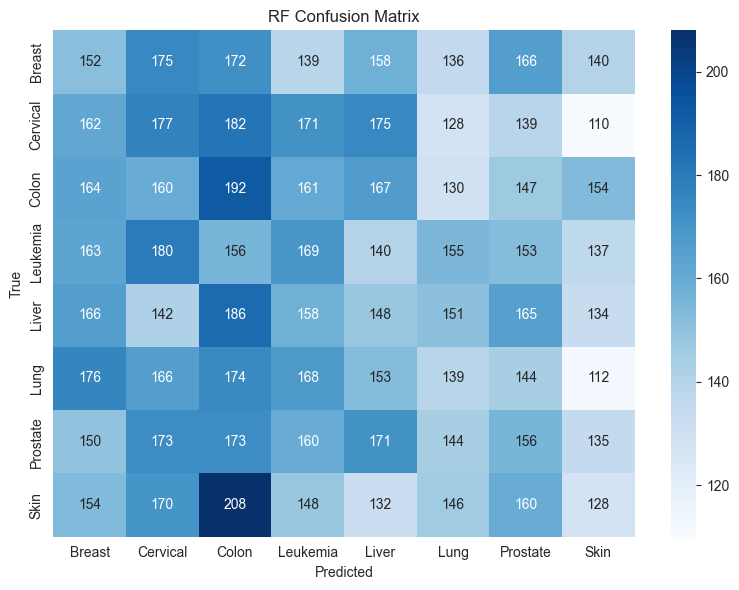

In [3]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Obliczamy macierz pomyłek dla RandomForest
cm = confusion_matrix(y_test, y_pred_rf)

# Rysujemy heatmapę z etykietami klas
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=label_enc.classes_,
            yticklabels=label_enc.classes_,
            cmap='Blues')

# Dodajemy tytuł i podpisy osi
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()
